# Introduction to Adaptive and Reliable Classification

This notebook provides an introductory usage example of the Adaptive and Reliable Classification (ARC) Python package.

Accompanying paper:
 - "Classification with Valid and Adaptive Coverage", Y. Romano, M. Sesia, E. Candès, 2020.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys
sys.path.insert(0, '..')
import arc
from arc import models
from arc import methods
from arc import black_boxes
from arc import others
from arc import coverage

C:\Anaconda\anaconda3\envs\Thesis\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Anaconda\anaconda3\envs\Thesis\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
np.random.seed(2020)                                   # Make this notebook reproducible

## Data

We generate data from a toy model with 10 explanatory variables and a qualitative label for each sample, which is designed to mimic "heteroschedasticity" in a classification setting.
More precisely, the first variable controls the "noise level" in the label: small values of $X_0$ mean that all labels are more or less equally likely; large values of $X_0$ mean that one label is much more likely than the others (which one is determined by the other features).
To clarify, we visualize below the distribution of the true label probabilities (for one value of the label) as a function of $X_0$, which here can take only two possible values for simplicity. 

In [3]:
p = 10                                                 # Number of features
K = 10                                                 # Number of possible labels
data_model = models.Model_Ex1(K,p)                     # Data generating model

n = 500                                                # Number of data samples
X = data_model.sample_X(n)                             # Generate the data features
Y = data_model.sample_Y(X)                             # Generate the data labels conditional on the features

n_test = 1000                                          # Number of test samples
X_test = data_model.sample_X(n_test)                   # Generate independent test data
Y_test = data_model.sample_Y(X_test)

## Evaluating prediction sets

We will evaluate prediction sets in terms of marginal coverage, estimated worst-slice conditional coverage, size, and size conditional on coverage.

In [4]:
def evaluate_predictions(S, X, y):
    marg_coverage = np.mean([y[i] in S[i] for i in range(len(y))])
    wsc_coverage = coverage.wsc_unbiased(X, y, S)
    length = np.mean([len(S[i]) for i in range(len(y))])
    idx_cover = np.where([y[i] in S[i] for i in range(len(y))])[0]
    length_cover = np.mean([len(S[i]) for i in idx_cover])
    print('Marginal coverage:       {:2.3%}'.format(marg_coverage))
    print('WS conditional coverage: {:2.3%}'.format(wsc_coverage))
    print('Average size:            {:2.3f}'.format(length))
    print('Average size | coverage: {:2.3f}'.format(length_cover))

## Oracle predictions

Since in this example we know the true data generating model, we can compute optimal prediction sets with an oracle.

In [7]:
alpha = 0.1                                            # Nominal coverage: 1-alpha 
oracle = others.Oracle(data_model, alpha)              # Classification oracle for this data model
S_oracle = oracle.predict(X_test)                      # Oracle prediction sets

In [8]:
evaluate_predictions(S_oracle, X_test, Y_test)         # Evaluate prediction sets

Marginal coverage:       88.600%
WS conditional coverage: 91.250%
Average size:            1.552
Average size | coverage: 1.623


Note that the oracle prediction sets have inhomogeneous sizes; some samples are more difficult to classify than others.

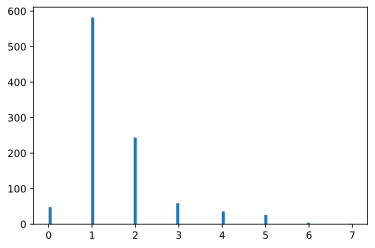

In [9]:
S_oracle_sizes = np.array([ len(s) for s in S_oracle ])
plt.hist(S_oracle_sizes, bins=100); plt.show()

It is easy to verify that the value of $X_0$ controls the difficulty of the classification problem.

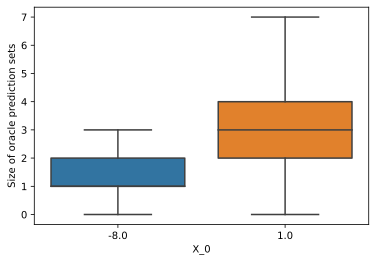

In [11]:
ax = sns.boxplot(x=X_test[:,0], y=S_oracle_sizes)
ax.set(xlabel='X_0', ylabel='Size of oracle prediction sets')
plt.show()

## ARC methods

First, we need to choose a black-box machine learning classifier to estimate the class probabilities, since the oracle normally does not exist because the true data-generating model is unknown.
Some wrappers for commonly used classifiers are provided in this package; others can be easily incorporated in the same style For example, we can use a support vector classifier (SVC), as implemented in [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). 

In [13]:
black_box = black_boxes.SVC(clip_proba_factor = 1e-5)

### ARC with split-conformal calibration

In [14]:
method_sc = methods.SplitConformal(X, Y, black_box, alpha)
S_sc = method_sc.predict(X_test)

In [15]:
evaluate_predictions(S_sc, X_test, Y_test)

Marginal coverage:       88.700%
WS conditional coverage: 83.871%
Average size:            2.235
Average size | coverage: 2.204


### ARC with CV+ calibration

In [16]:
method_cv = methods.CVPlus(X, Y, black_box, alpha, n_folds=10)
S_cv = method_cv.predict(X_test)

In [17]:
evaluate_predictions(S_cv, X_test, Y_test)

Marginal coverage:       91.800%
WS conditional coverage: 96.000%
Average size:            2.236
Average size | coverage: 2.325


### ARC with Jackknife+ calibration

In [18]:
method_jk = methods.JackknifePlus(X, Y, black_box, alpha)
S_jk = method_jk.predict(X_test)

In [19]:
evaluate_predictions(S_jk, X_test, Y_test)

Marginal coverage:       90.800%
WS conditional coverage: 85.567%
Average size:            2.143
Average size | coverage: 2.239


### ARC with oracle black-box

As an example, we can also apply ARC with an oracle black-box that knows the true conditional probabilities (in combination with any choice of calibration method).

In [20]:
oracle_black_box = black_boxes.Oracle(data_model)
method_oracle_cv = methods.CVPlus(X, Y, oracle_black_box, alpha)
S_oracle_cv = method_oracle_cv.predict(X_test)

In [21]:
evaluate_predictions(S_oracle_cv, X_test, Y_test)

Marginal coverage:       87.300%
WS conditional coverage: 86.957%
Average size:            1.473
Average size | coverage: 1.562


## Other conformal classification methods

Finally, we have also implemented some benchmark alternative methods.

### Homogeneous split-conformal classification

In [22]:
method_oracle_hcc = others.SplitConformalHomogeneous(X, Y, oracle_black_box, alpha)
S_oracle_hcc = method_oracle_hcc.predict(X_test)
evaluate_predictions(S_oracle_hcc, X_test, Y_test)

Marginal coverage:       89.600%
WS conditional coverage: 69.643%
Average size:            1.265
Average size | coverage: 1.259


### Conformal quantile classification

In [23]:
method_oracle_cqc = others.CQC(X, Y, oracle_black_box, alpha)
S_oracle_cqc = method_oracle_cqc.predict(X_test)
evaluate_predictions(S_oracle_cqc, X_test, Y_test)

Marginal coverage:       85.400%
WS conditional coverage: 82.667%
Average size:            1.678
Average size | coverage: 1.847
